In [ ]:
from importnb import Notebook
with Notebook():
    import news_analysis
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sshtunnel import SSHTunnelForwarder
import pymongo
import datetime
import pickle
from glob import glob
import re
from copy import deepcopy
from multiprocessing import Pool
from tqdm import tqdm_notebook
from collections import Counter
from joblib import delayed, Parallel

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.ensemble import VotingClassifier
from xgboost import XGBRegressor, XGBClassifier
import hyperopt
from hyperopt import hp

import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
PATH_TO_DATA = 'data/twitter_models/'

#### Metrics

In [ ]:
def accuracy(y_true, y_pred):
    return metrics.accuracy_score(y_true, y_pred)

def precision(y_true, y_pred): # price up is positive if not down
    return metrics.precision_score(y_true, y_pred)

def recall(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.recall_score(y_true, y_pred)

def f1_score(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.f1_score(y_true, y_pred)

def roc_auc(y_true, y_pred, down=False): # price up is positive if not down
    return metrics.roc_auc_score(y_true, y_pred)
    
def summary(y_true, y_pred):
    l = []
    l.append('Acc: ' + str(accuracy(y_true, y_pred)))
    l.append('Precison: ' + str(precision(y_true, y_pred)))
    l.append('Recall: ' + str(recall(y_true, y_pred)))
    l.append('F1: ' + str(f1_score(y_true, y_pred)))
    l.append('ROC AUC: ' + str(roc_auc(y_true, y_pred)))
    l.append('Confusion matrix:')
    print('\n'.join(l))
    conf_matr = metrics.confusion_matrix(y_true, y_pred, labels=[0,1])
    print(pd.DataFrame({str(i): conf_matr[:,i]for i in [0,1]}))

#### Downloading database from server

In [ ]:
def load_collection(db, collection):
    MONGO_HOST = "148.251.21.37"
    MONGO_DB = "cryptopanic_latest"
    MONGO_USER = "andrii"
    MONGO_PASS = "andrii"
    
    server = SSHTunnelForwarder(
        MONGO_HOST,
        ssh_username=MONGO_USER,
        ssh_password=MONGO_PASS,
        remote_bind_address=('127.0.0.1', 27017)
    )
    
    server.start()
    l = []
    try:
        client = pymongo.MongoClient('127.0.0.1', server.local_bind_port)
        c = client[db]
        col = c[collection]
        n_rec = col.count_documents({})
        print('Total records:', n_rec)
        cursor = col.find()
        l = []
        for rec in tqdm_notebook(cursor, total=n_rec):
            l.append(rec)
        
    except Exception as e:
        print(e)

    server.close()  
    df = pd.DataFrame(l)
    return df


def dump_dataframe(df, name):
    pickle.dump(df, open(name+datetime.datetime.now().strftime("%Y%m%dT%H%M")+'.pkl', 'wb'))
    
def load_dataframe_latest(name):
    paths = glob(name+'*.pkl')
    dates = np.array([datetime.datetime.strptime(
                                    re.findall(pattern='([0-9]{8}T[0-9]{4})', string=path)[0], '%Y%m%dT%H%M') 
                             for path in paths])

    last_df = name+dates.max().strftime("%Y%m%dT%H%M")+'.pkl'
    df = pickle.load(open(last_df, 'rb'))
    return df

#### Loading latest DataFrame

In [ ]:
df_users = load_dataframe_latest(PATH_TO_DATA+'df_users')
df_tweets = load_dataframe_latest(PATH_TO_DATA+'df_tweets')

#### Some changes to DataFrames

In [ ]:
def moving_sum(a, window):
    b = np.concatenate([np.zeros(window-1), a])
    A = np.concatenate([b[i:b.shape[0]-window+1+i].reshape(-1,1) for i in range(window)], axis=1)
    ms = A.sum(axis=1)
    return ms

def moving_average(a, window):
    ms = moving_sum(a, window)
    ma = ms / np.concatenate([np.arange(1,window), np.ones(ms.shape[0] - window + 1) * window])
    return ma

In [ ]:
assert Counter(df_users.id).most_common()[0][1] == 1
assert Counter(df_tweets.id).most_common()[0][1] == 1
df_users.set_index('id', inplace=True)
df_tweets.set_index('id', inplace=True)

In [ ]:
def add_user_info(df_tweets, df_users):
    df = df_tweets.copy()
    columns = ['followers', 'friends', 'tweets']
    ar = np.array([df_users.loc[user][columns].values for user in tqdm_notebook(df.id_user_owner.values)])
    for i, column in enumerate(columns):
        df[column] = ar[:,i]
    return df

In [ ]:
df = add_user_info(df_tweets, df_users)

In [ ]:
ts = df.created_at.values.astype(datetime.datetime) // 1000000000
df['created_at'] = np.array(list(map(datetime.datetime.fromtimestamp, ts)))
df.set_index(ts, inplace=True)
df.sort_index(inplace=True)

In [ ]:
Counter(df.kind.values)

In [ ]:
kind_dict = {'tweet': 0,'retweeted': 1,'retweeted-reply': 2,'quoted': 3,'quoted-reply': 4}
df['kind'] = df['kind'].apply(lambda x: kind_dict[x])

In [ ]:
df = df.loc[:,['created_at', 'kind', 'likes', 'retweets', 'text']]

In [ ]:
window_likes = 100
for column in ['likes', 'retweets']:
    df[column+'_ma'] = moving_average(df[column].values, 100)

In [ ]:
df.head()

#### Downloading prices

In [ ]:
def to_datetime(iterable, pattern='%Y-%m-%dT%H:%M', period_seconds=5*60):
    '''
    patterns:
    '%m/%d/%Y %H:%M' for `date_modified`
    '%Y-%m-%dT%H:%M' for `created_at`
    '''
    dates = np.array([datetime.datetime.strptime(date_str[:16], pattern) for date_str in iterable])
    dates = np.array([datetime.datetime.fromtimestamp((date.timestamp() // period_seconds) * period_seconds) for date in dates])
    return dates

def download_prices(start=1405699200, end=9999999999, period_seconds=300, currency='BTC'):
    '''
    download prices (pair USDT/BTC) from poloniex
    returns dataframe
    '''
    address = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_'+currency+'&start='+ \
                str(start)+'&end='+str(end)+'&period='+str(period_seconds)
    df_prices = pd.read_json(address)
    return df_prices

def get_prices_at_date(timestamps, df_prices, price='close', period=5*60):
    '''
    timestamps and prices need to be sorted
    '''
    prices = []
    df = df_prices.copy()
    prices_ts = df.date.values.astype(datetime.datetime) // 1000000000
    
    s_prices = df_prices.loc[:,price]
    s_prices.index = prices_ts
    
    dates = (timestamps // period) * period
    for date in tqdm_notebook(dates):
        
        if date in s_prices.index:
            prices.append(s_prices[date])
        else:
            prices.append(0)
    return np.array(prices)

In [ ]:
prices0 = get_prices_at_date(df.index.values, df_prices)
prices1 = get_prices_at_date(df.index.values + 6*60*60, df_prices)

In [ ]:
df['price'] = prices0
df['target'] = prices1
df = df[df.price > 0]

#### Split dataset

In [ ]:
# CENSORED_WORDS, CENSORED_NLEMMAS = news_analysis._get_censored_nlemmas(last_db_news)

class D2Vmodel:
    def __init__(self, vector_size=10, window=2, min_count=1, n_jobs=1, alpha=0.1, min_alpha=0.0001, steps=5, censored=False):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.d2v_model = None
        self.n_jobs = n_jobs
        self.censored = censored
        self.alpha = alpha
        self.min_alpha = min_alpha
        self.steps = steps
    
    def fit_transform(self, titles, verbose=0):
        texts = self._preprocess(titles)
        if verbose > 0:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tqdm_notebook(texts, desc='tag'))]
        else:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
        self.d2v_model = Doc2Vec(documents, 
                                 vector_size=self.vector_size, 
                                 window=self.window, 
                                 min_count=self.min_count, 
                                 workers=self.n_jobs)
        if verbose > 0:
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in tqdm_notebook(texts, desc='fit')])
        else: 
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in texts])
        return X
    
    def transform(self, titles, verbose=0):
        texts = self._preprocess(titles)
        if verbose > 0:
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in tqdm_notebook(texts, desc='fit')])
        else: 
            X = np.array([self.d2v_model.infer_vector(text, self.alpha, self.min_alpha, self.steps) 
                          for text in texts])
        return X
    
    def _preprocess(self, titles):
        texts = news_analysis._get_texts(titles)
        if self.censored:
            texts = news_analysis._censor(texts, CENSORED_WORDS, CENSORED_NLEMMAS)
        return texts

def split_data(df, train_size, lag):
    train, test = train_test_split(df, train_size=train_size, shuffle=False)
    last_train = train.index.values[-1]
    test = test[test.index.values >= last_train + lag]
    return train, test
    
def d2v_fit_transform_dataframe(df_train, df_test, d2v, verbose=0):
    texts_train, texts_test = df_train.text.values, df_test.text.values
    df_train, df_test = df_train.drop(columns='text'), df_test.drop(columns='text')
    emb_train = d2v.fit_transform(texts_train, verbose=1)
    emb_test = d2v.transform(texts_test, verbose=1)
    for i in range(emb_train.shape[1]):
        df_train['emb'+str(i)] = emb_train[:,i]
        df_test['emb'+str(i)] = emb_test[:,i]
    return df_train, df_test

#### Preprocess data

In [ ]:
def series_to_dataset(df, window):
    dfs = [df.drop(columns='target').iloc[i:df.shape[0]+i-window+1] for i in range(window)]
    for i in range(window):
        dfs[i]['timestamp'] = dfs[i].index.values
        dfs[i].columns = dfs[i].columns + '_' + str(i)
        dfs[i].set_index(np.arange(dfs[i].shape[0]), inplace=True)
    dataset = pd.concat(dfs, axis=1)
    dataset.set_index(df.index.values[window-1:], inplace=True)
    dataset['target'] = df.target.values[window-1:]
    return dataset

def get_target_up(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if t < threshold else 1 for t in target]
    return np.array(target_class)

def get_target_down(prices0, prices1, threshold=0.002):
    target = prices1 / prices0 - 1
    target_class = [0 if t > - threshold else 1 for t in target]
    return np.array(target_class)

def get_X_y(dataset, target_function, threshold=0.002):
    target = dataset.target.values
    price_columns = []
    for col in dataset.columns:
        if 'price_' in col:
            price_columns.append(col)
    prices0 = dataset.loc[:,price_columns[np.array([int(col[6:]) for col in price_columns]).argmax()]].values
    prices1 = dataset.target.values
    y = target_function(prices0, prices1, threshold)
    X = dataset.drop(columns='target')
    return X, y

In [ ]:
X_up_train, X_up_test, y_up_train, y_up_test = pickle.load(open(PATH_TO_DATA+'X_y_up.pkl', 'rb'))
X_down_train, X_down_test, y_down_train, y_down_test = pickle.load(open(PATH_TO_DATA+'X_y_down.pkl', 'rb'))

## Hyperparameters optimization

In [ ]:
class ObjectiveFunctionBase:
    def __init__(self, X, y, scoring_function, k_folds=10, verbose=1,
                 log_path=PATH_TO_DATA+'logs/'):
        self.X = X
        self.y = y
        self.scoring_function = scoring_function
        self.k_folds = k_folds
        self.verbose = verbose
        self.iteration = 0
        self.log_csv = log_path + 'Base_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv'

    def _get_estimator(self, X):
        assert True, 'Can not __call__ with _get_estimator of ObjectiveFunctionBase'
        
    def _set_log(self, log_csv):
        self.log_csv = log_csv
        
    # Calculate cross validation score (default is 10-fold CV)
    def __call__(self, X):
        self.iteration += 1
        print('Iteration:', self.iteration)
        estimator = self._get_estimator(X)
        cv = StratifiedKFold(n_splits=self.k_folds, shuffle=False)
        scorer = metrics.make_scorer(self.scoring_function)
        scores = cross_val_score(estimator, self.X, self.y, cv=cv,scoring=scorer,n_jobs=-1)
        mean_score = np.mean(scores)
        if self.verbose > 0:
            print('params:', X)
            print('Scores:', scores)
            print('Mean score:', mean_score)
            print()
        if self.iteration == 1:
            df_log = pd.DataFrame(columns=list(X.keys()) + ['scores', 'mean_score'])
            df_log.to_csv(self.log_csv)
        new_row = {item[0]: item[1] for item in X.items()}
        new_row['scores'] = scores
        new_row['mean_score'] = mean_score
        df_log = pd.read_csv(self.log_csv).loc[:,list(new_row.keys())]
        df_log = df_log.append(new_row, ignore_index=True)
        df_log.to_csv(self.log_csv)
        return - mean_score    # for minimization
    
class ObjectiveFunctionXGBClassifier(ObjectiveFunctionBase):
    def __init__(self, X, y, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionXGBClassifier, self).__init__(X, y, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'XGBclf_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return XGBClassifier(   max_depth=int(X['max_depth']),
                                learing_rate=3**X['learing_rate'],
                                n_estimators=int(2**X['n_estimators']),
                                objective=X['objective'],
                                booster=X['booster'],
                                min_child_weight=int(X['min_child_weight']),
                                max_delta_step=int(X['max_delta_step']))
    
class ObjectiveFunctionRandomForestClassifier(ObjectiveFunctionBase):
    def __init__(self, X, y, scoring_function, k_folds=10, verbose=1, log_path=PATH_TO_DATA+'logs/'):
        super(ObjectiveFunctionRandomForestClassifier, self).__init__(X, y, scoring_function, 
                                            k_folds, verbose)
        ObjectiveFunctionBase._set_log(self, log_path + 'RFclf_' + datetime.datetime.now().strftime('%Y%m%dT%H%M') + '.csv')
    
    def _get_estimator(self, X):
        return RandomForestClassifier(max_depth=int(1.2**X['max_depth']), 
                                      n_estimators=int(2**X['n_estimators']),
                                     min_samples_leaf=int(X['min_samples_leaf']))

In [ ]:
parameter_space = {'max_depth':hp.quniform('max_depth',2,20,q=1),
                  'learing_rate':hp.uniform('learing_rate',-5,-1),
                  'n_estimators':hp.quniform('n_estimators',3,8,q=1),
                   'objective':hp.choice('objective',['reg:linear','reg:logistic','binary:logistic']),
                  'booster':hp.choice('booster',['gbtree', 'gblinear', 'dart']),
                  'min_child_weight':hp.quniform('min_child_weight',1,5,q=1),
                  'max_delta_step':hp.quniform('max_delta_step',0,5,q=1)}

In [ ]:
%%time
f_xgb_up = ObjectiveFunctionXGBClassifier(X_up_train, y_up_train, metrics.recall_score, k_folds=4)
trials = hyperopt.Trials()
best = hyperopt.fmin(f_xgb_up, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=3, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
f_xgb_down = ObjectiveFunctionXGBClassifier(df_down, metrics.f1_score, k_folds=4)
trials = hyperopt.Trials()

In [ ]:
%%time
best = hyperopt.fmin(f_xgb_down, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=100, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
f_rf_up = ObjectiveFunctionRandomForestClassifier(df_up, metrics.f1_score, k_folds=4)
trials = hyperopt.Trials()
parameter_space = {'max_depth':hp.quniform('max_depth',8,35,q=1),
                  'n_estimators':hp.uniform('n_estimators',3,10),
                  'min_samples_leaf':hp.quniform('min_samples_leaf',2,15,q=1)}

In [ ]:
%%time
best = hyperopt.fmin(f_rf_up, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=100, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
f_rf_down = ObjectiveFunctionRandomForestClassifier(df_down, metrics.f1_score, k_folds=4)
trials = hyperopt.Trials()

In [ ]:
%%time
best = hyperopt.fmin(f_rf_down, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=100, trials=trials, verbose=1)
print("best estimate parameters", best)

#### Test

In [ ]:
df_test = pickle.load(open(PATH_TO_DATA+'dataset_test.pkl', 'rb'))
df_up_test = df_test.drop(['Y_down', 'target'], axis=1).rename(columns={'Y_up':'Y'})
df_down_test = df_test.drop(['Y_up', 'target'], axis=1).rename(columns={'Y_down':'Y'})

In [ ]:
X_up_train, Y_up_train = df_up.drop('Y', axis=1).values, df_up['Y'].values
X_down_train, Y_down_train = df_down.drop('Y', axis=1).values, df_down['Y'].values
X_up_test, Y_up_test = df_up_test.drop('Y', axis=1).values, df_up_test['Y'].values
X_down_test, Y_down_test = df_down_test.drop('Y', axis=1).values, df_down_test['Y'].values

In [ ]:
xgb_up = XGBClassifier(max_depth=3,
                        learing_rate=3**-1.774218508406182,
                        n_estimators=int(2**6),
                        objective='reg:linear',
                        booster='dart',
                        min_child_weight=5,
                        max_delta_step=3, 
                        nthread=-1)
xgb_down = XGBClassifier(max_depth=5,
                        learing_rate=3**-2.4751503456340562,
                        n_estimators=int(2**3),
                        objective='reg:logistic',
                        booster='dart',
                        min_child_weight=1,
                        max_delta_step=2, 
                        nthread=-1)
rf_up = RandomForestClassifier(max_depth=int(1.2**19),
                               min_samples_leaf=7,
                               n_estimators=int(2**3.3453193469804283),
                               n_jobs=-1)
rf_down = RandomForestClassifier(max_depth=int(1.2**8),
                                min_samples_leaf=5,
                                n_estimators=int(2**7.180527387650649),
                                n_jobs=-1)

In [ ]:
%%time
xgb_up.fit(X_up_train, Y_up_train)
xgb_down.fit(X_down_train, Y_down_train)
rf_up.fit(X_up_train, Y_up_train)
rf_down.fit(X_down_train, Y_down_train)

In [ ]:
%%time
pred_xgb_up = xgb_up.predict(X_up_test)
pred_xgb_down = xgb_down.predict(X_down_test)
pred_rf_up = rf_up.predict(X_up_test)
pred_rf_down = rf_down.predict(X_down_test)

In [ ]:
f = pd.DataFrame()
f['names']  = list(df_down_test.drop('Y', axis=1).columns)
f['importance'] = xgb_down.feature_importances_
f.sort_values(by='importance', ascending=False)

In [ ]:
np.bincount(Y_up_test)

In [ ]:
np.bincount(pred_xgb_up)

In [ ]:
print('\tXGB up')
summary(Y_up_test, pred_xgb_up)
print()
print('\tXGB down')
summary(Y_down_test, pred_xgb_down)
print()
print('\tRF up')
summary(Y_up_test, pred_rf_up)
print()
print('\tRF down')
summary(Y_down_test, pred_rf_down)

w/ preprocessing, w/o censoring
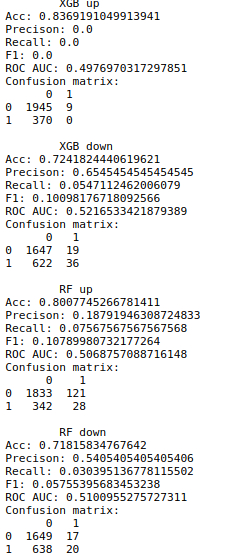

## Stacking models

### Up

In [ ]:
def profit_score(true, pred, price0, price1, fee=0.001, double_fee=False):
    '''
    if pred > 0 then buy
    if pred < 0 then sell
    '''
    profits = []
    price_abs_diff = price1 - price0
    for i in range(len(true)):
        if pred[i] != 0:
            profits.append(np.sign(pred[i]) * price_abs_diff[i] - (price0[i] + double_fee * price1[i]) * fee)
        else:
            profits.append(0)
    profits = np.array(profits)
    return profits.sum(), profits

price0 = df_test.price_9.values
price1 = df_test.target.values

In [ ]:
est_rf_up = [('rf'+str(i), RandomForestClassifier(max_depth=int(1.2**19),
                               min_samples_leaf=7,
                               n_estimators=int(2**3.3453193469804283),
                               n_jobs=1)) 
               for i in range(10)]
ens_rf_up = VotingClassifier(est_rf_up, n_jobs=-1)

In [ ]:
ens_rf_up.fit(X_up_train, Y_up_train)

# Using precision metrics

In [ ]:
parameter_space = {'max_depth':hp.quniform('max_depth',2,20,q=1),
                  'learing_rate':hp.uniform('learing_rate',-5,-1),
                  'n_estimators':hp.quniform('n_estimators',3,8,q=1),
                   'objective':hp.choice('objective',['reg:linear','reg:logistic','binary:logistic']),
                  'booster':hp.choice('booster',['gbtree', 'gblinear', 'dart']),
                  'min_child_weight':hp.quniform('min_child_weight',1,5,q=1),
                  'max_delta_step':hp.quniform('max_delta_step',0,5,q=1)}

In [ ]:
%%time
f_xgb_up = ObjectiveFunctionXGBClassifier(df_up, metrics.recall_score, k_folds=4)
trials = hyperopt.Trials()

best = hyperopt.fmin(f_xgb_up, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=300, trials=trials, verbose=1)
print("best estimate parameters", best)

In [ ]:
parameter_space = {'max_depth':hp.quniform('max_depth',8,35,q=1),
                  'n_estimators':hp.uniform('n_estimators',3,10),
                  'min_samples_leaf':hp.quniform('min_samples_leaf',2,15,q=1)}

In [ ]:
%%time
f_rf_up = ObjectiveFunctionRandomForestClassifier(df_up, metrics.recall_score, k_folds=4)
trials = hyperopt.Trials()

best = hyperopt.fmin(f_rf_up, parameter_space, 
                     algo=hyperopt.tpe.suggest, max_evals=300, trials=trials, verbose=1)
print("best estimate parameters", best)

#### Test

In [ ]:
df_test = pickle.load(open(PATH_TO_DATA+'dataset_test.pkl', 'rb'))
df_up_test = df_test.drop(['Y_down', 'target'], axis=1).rename(columns={'Y_up':'Y'})
df_down_test = df_test.drop(['Y_up', 'target'], axis=1).rename(columns={'Y_down':'Y'})

X_up_train, Y_up_train = df_up.drop('Y', axis=1).values, df_up['Y'].values
X_down_train, Y_down_train = df_down.drop('Y', axis=1).values, df_down['Y'].values
X_up_test, Y_up_test = df_up_test.drop('Y', axis=1).values, df_up_test['Y'].values
X_down_test, Y_down_test = df_down_test.drop('Y', axis=1).values, df_down_test['Y'].values

In [ ]:
xgb_up = XGBClassifier(max_depth=3,
                        learing_rate=3**-1.912594765190702,
                        n_estimators=int(2**8),
                        objective='reg:linear',
                        booster='gbtree',
                        min_child_weight=3,
                        max_delta_step=0, 
                        nthread=-1)
xgb_down = XGBClassifier(max_depth=3,
                        learing_rate=3**-4.177129236828251,
                        n_estimators=int(2**4),
                        objective='reg:linear',
                        booster='dart',
                        min_child_weight=4,
                        max_delta_step=0, 
                        nthread=-1)
rf_up = RandomForestClassifier(max_depth=int(1.2**16),
                               min_samples_leaf=5,
                               n_estimators=int(2**3.803521739088288),
                               n_jobs=-1)
rf_down = RandomForestClassifier(max_depth=int(1.2**9),
                                min_samples_leaf=11,
                                n_estimators=int(2**6.41045407428725),
                                n_jobs=-1)

In [ ]:
%%time
xgb_up.fit(X_up_train, Y_up_train)
xgb_down.fit(X_down_train, Y_down_train)
rf_up.fit(X_up_train, Y_up_train)
rf_down.fit(X_down_train, Y_down_train)

In [ ]:
%%time
pred_xgb_up = xgb_up.predict(X_up_test)
pred_xgb_down = xgb_down.predict(X_down_test)
pred_rf_up = rf_up.predict(X_up_test)
pred_rf_down = rf_down.predict(X_down_test)

In [ ]:
f = pd.DataFrame()
f['names']  = list(df_down_test.drop('Y', axis=1).columns)
f['importance'] = xgb_down.feature_importances_
f.sort_values(by='importance', ascending=False)

In [ ]:
np.bincount(Y_up_test)

In [ ]:
np.bincount(pred_xgb_up)

In [ ]:
print('\tXGB up')
summary(Y_up_test, pred_xgb_up)
print()
print('\tXGB down')
summary(Y_down_test, pred_xgb_down)
print()
print('\tRF up')
summary(Y_up_test, pred_rf_up)
print()
print('\tRF down')
summary(Y_down_test, pred_rf_down)